## learning-AI : MNIST self-supervised learning using autoencoder
### MNIST dataset을 autoencoder에 접목시켜 원리 이해

<br>

- **임규연 (lky473736)**
- 2024.10.03.에 문서 작성
- **dataset** : MNIST dataset
- **data abstract** : The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

------



## <span id='dl'><mark>DL</mark></span>
    
keras에 자체 내장되어 있는 MNIST 손글씨 dataset을 이용하여 autoencoder로 학습시킨 후, self-supervised learning의 전반적인 이해를 돕기 위해 encoder가 학습한 이미지, decoder가 복원한 이미지 등을 확인해본다.

- **Reference**
    - https://yann.lecun.com/exdb/mnist/
    - https://www.youtube.com/watch?v=qiUEgSCyY5o
    - https://blog.keras.io/building-autoencoders-in-keras.html
    - https://keraskorea.github.io/posts/2018-10-23-keras_autoencoder
    - https://github.com/HyoYoonNam/DL-Class/blob/main/Exam_AutoEncoder_MNIST.ipynb

In [408]:
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [409]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


-----

### autoencoder의 원리와 self-supervised learning

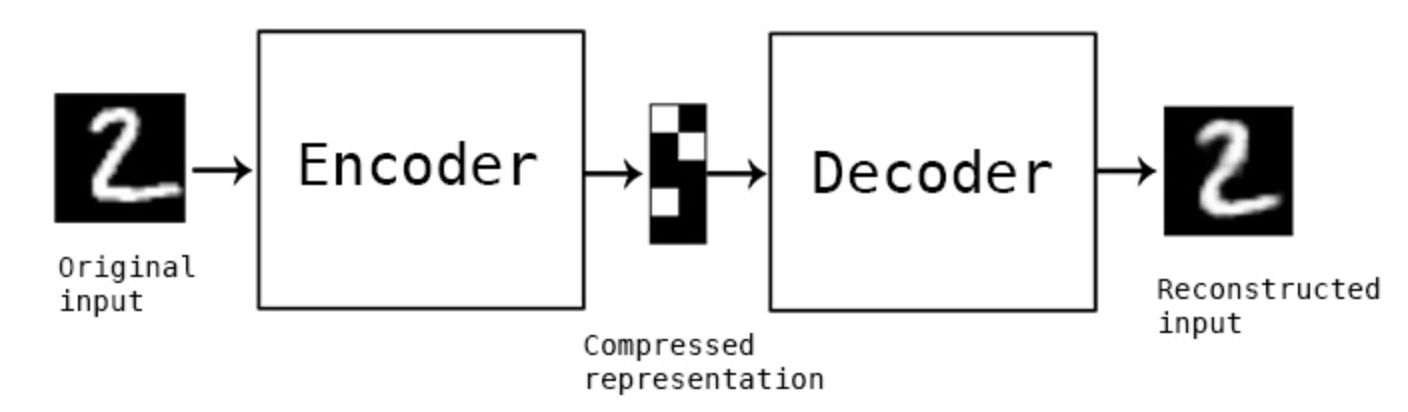

autoencoder는 위와 같은 구조를 가진다. 좌측은 encoder, 가운데가 latent space, 우측이 decoder이다. 각각은 아래와 같은 역할을 하며, 가장 큰 목적은 **완전히 똑같을 수는 없지만, input과 굉장히 흡사한 데이터를 생성해내는 것.** 자기 자신을 input하여 또 다른 자신을 만들어내는 이 과정을 **self-supervised learning**이라고 부른다. autoencoder가 여기서 학습하는 것은 **데이터의 노이즈 및 특징을 보고 어떻게 control하여 얼마나 기존 데이터와 유사할 것인가**이다.

- **encoder** : 데이터의 feature를 extraction하여 중요한 정보만을 압축함. convolution layer가 들어갈 수도 있고, dense layer가 들어갈 수도 있으며, 유형마다 들어가는 layer은 당연히 다르다.
- **latent space** : encoder를 거쳐 압축된 데이터가 있는 공간, encoder와 decoder의 일종의 bridge
- **decoder** : latent space를 보고 다시 원래 input size로 복원하는 곳. 
    - **여기서 만약 encoder와 나란히 concatenate하면 U-net이 된다**
   

<img src="./what_are_autoencoder.png" width='500px'>

위 figure은 IBM Technology에서 제공하는 유튜브 동영상인 **"What are Autoencoder?"** 에서 나온 간단한 encoder-decoder 그림이다. 위와 같듯이, autoencoder에 3을 입력한다고 가정한다면, encoder는 3에서의 **정말 중요한 정보 (꼭짓점, 변곡점, threshold...)와 같은 정보를 응집하고**, decoder는 **그 정보를 가지고 원래 크기로 복구하면서, 원 데이터와 최대한 비슷하게 구성하려고 한다.** 이를 통해서 원본보다 더 해상도 좋은 이미지를 만들거나, 흑백인 이미지를 컬러인 이미지로 변경시키는 등과 같은 활용을 할 수 있다. 더 나아가서, input을 노이즈가 묻어있는 손글씨 이미지, target을 노이즈가 제거된 손글씨 이미지를 학습시켜서 노이즈를 제거해주는 모델을 만들 수도 있는 것이다.

보통 autoencoder는 **Anomaly Detection**을 할 때 사용한다. 얼마나 유사하게 할 것인가를 학습하는 모델이니, 들어오는 데이터의 유사도를 체크할 수 있게 된다. 따라서 오류 탐지 및 이상치 감지에 사용할 수 있는 것이다.

현재 이 문서를 통해 하고 싶은 것은, MNIST 데이터셋을 autoencoder로 학습시킨 후, encoder가 만들어 낸 latent space의 모습과, 모든 path를 끝내고 만들어낸 이미지가 기존과 정말 비슷한지를 확인해보고자 하는 것이다.

### MNIST 데이터셋을 autoencoder로 학습 및 latent space, result 시각화

In [410]:
# 데이터 준비, 데이터를 4차원으로 변환 (channel 추가)

from keras.datasets import mnist
import numpy as np

(X_train, _), (X_test, _) = mnist.load_data()

input_shape = (X_train.shape[1], X_train.shape[2])

print (X_train.shape, X_test.shape)

X_train = X_train.reshape((-1, 28, 28, 1)) # (60000, 28, 28) -> (60000, 28, 28, 1)
X_test = X_test.reshape((-1, 28, 28, 1))

print (X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [411]:
# z-score normalization, reshape

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))) # 1차원 ndarray로 만듦
# X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print (X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [412]:
# modeling autoencoder

from keras.layers import Input, Dense, Reshape, Flatten
from keras.models import Sequential

encoding_dim = 32
input_shape = (28, 28, 1)

model = Sequential()

# input
model.add(Input(shape=input_shape))
model.add(Flatten())

# encoder
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))

# latent space
model.add(Dense(units=encoding_dim, activation='relu'))

# decoder
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=256, activation='relu'))

# output
model.add(Dense(units=input_shape[0] * input_shape[1], activation='sigmoid'))
model.add(Reshape(input_shape))

'''
    왜 sigmoid를 사용해야 하는가
    - softmax는 다중 클래스 문제에 어울림. 현재는 입력이 들어온 이미지를 복원하는 것에 초점을 맞추어야 하며, 
      그 이미지 복원은 각 픽셀 당 0~1값을 가지도록 해야 하기 때문 (MNIST를 normalization하였기 때문에)
'''

'\n    왜 sigmoid를 사용해야 하는가\n    - softmax는 다중 클래스 문제에 어울림. 현재는 입력이 들어온 이미지를 복원하는 것에 초점을 맞추어야 하며, \n      그 이미지 복원은 각 픽셀 당 0~1값을 가지도록 해야 하기 때문 (MNIST를 normalization하였기 때문에)\n'

In [413]:
# 모두 summary 

model.summary()

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_38 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_89 (Reshape)            │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,136 (1.87 MB)

 Trainable params: 489,136 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [414]:
# compile

from keras.optimizers import Adam

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy')

In [415]:
# fit

history = model.fit(X_train, X_train,
                epochs=25,
                batch_size=512,
                shuffle=True,
                validation_data=(X_test, X_test)) # 자기 자신을 input, target하는 것을 확인할 수 있다.

Epoch 1/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.3862 - val_loss: 0.2209
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1986 - val_loss: 0.1603
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1557 - val_loss: 0.1409
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1396 - val_loss: 0.1322
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1318 - val_loss: 0.1262
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1254 - val_loss: 0.1208
Epoch 7/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1205 - val_loss: 0.1166
Epoch 8/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1168 - val_loss: 0.1137
Epoch 9/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1131 - val_loss: 0.1107
Epoch 10/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1106 - val_loss: 0.1089
Epoch 11/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1087 - val_loss: 0.1059
Epoch 12/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 

{'loss': [0.29521089792251587, 0.18329493701457977, 0.15107238292694092, 0.1372578740119934, 0.13019528985023499, 0.12428313493728638, 0.11969932168722153, 0.1158694326877594, 0.11249962449073792, 0.10995852202177048, 0.10794767737388611, 0.10595943033695221, 0.10453326255083084, 0.10316507518291473, 0.1016777828335762, 0.10059244930744171, 0.09945958852767944, 0.09829862415790558, 0.097270168364048, 0.09631896764039993, 0.09564447402954102, 0.09485068917274475, 0.09411783516407013, 0.09357823431491852, 0.09278622269630432], 'val_loss': [0.2209012508392334, 0.16034425795078278, 0.14090780913829803, 0.13219070434570312, 0.1261577159166336, 0.12079213559627533, 0.1165587306022644, 0.11367134749889374, 0.110682912170887, 0.10892150551080704, 0.10594955086708069, 0.10454067587852478, 0.10422424226999283, 0.10225268453359604, 0.10110364109277725, 0.09955812990665436, 0.09872326999902725, 0.09746287018060684, 0.09638210386037827, 0.09543462097644806, 0.09621422737836838, 0.09521324932575226,

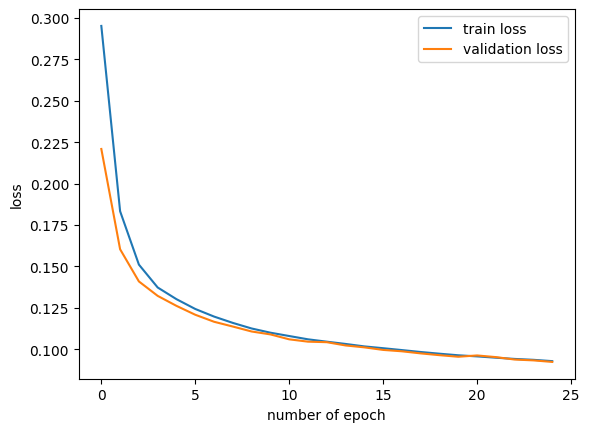

'\n    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.\n'

In [416]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

'''
    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.
'''

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


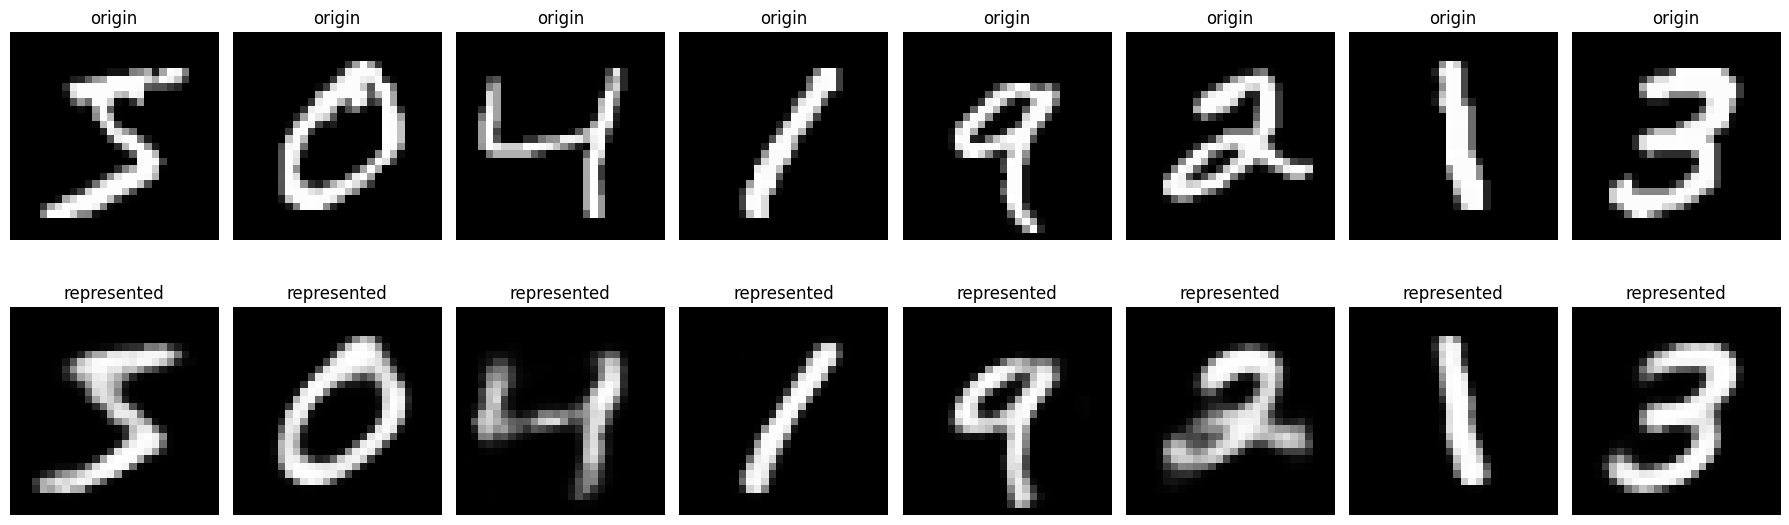

In [417]:
# visualization

X_represented = model.predict(X_train)

def visualization(x1, x2): 
    figure, axs = plt.subplots(2, 8, figsize=(18, 6), tight_layout=True)

    for i in range(8):
        img1 = x1[i]  # x1에서 이미지를 가져옴
        axs[0, i].imshow(img1.reshape(28, 28), cmap='gray')
        axs[0, i].set_title('origin')
        axs[0, i].axis('off')

        img2 = x2[i]  # x2에서 이미지를 가져옴
        axs[1, i].imshow(img2.reshape(28, 28), cmap='gray')
        axs[1, i].set_title('represented')
        axs[1, i].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

visualization(X_train, X_represented)


위를 확인해보았을 때, **origin에서 원래 숫자 형태에서 약간 삐져나온 것 (잉크가 옆으로 뭍어나온 것, 2번째 origin 0의 윗쪽 부분처럼) 이 represented에서는 감쇄된 것을 확인할 수 있다.** 그리고 전체적으로 origin과 유사도가 높으면서도, 인식하는 데에 불필요한 정보를 최대한 줄인 것이 눈에 보인다.

https://github.com/HyoYoonNam/DL-Class/blob/main/Exam_AutoEncoder_MNIST.ipynb 에 나와있는 뒷쪽 encoder로 학습된 결과를 출력하는 소스를 참고하여, transfer-learning을 적용하여 latent space 이전 encoder의 extraction한 map을 확인해보겠다. 

In [418]:
# 모델 저장하기 및 base loss 계산

base_loss = model.evaluate(X_test, X_test)
autoencoder_file = './model/autoencoder_MNIST.h5'
tf.keras.models.save_model(model, autoencoder_file, include_optimizer=False)

print('model saved at ', autoencoder_file)
print('Base Loss >{:.2f}'.format(base_loss))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0923


model saved at  ./model/autoencoder_MNIST.h5
Base Loss >0.09


In [419]:
# 모델 불러오기

from tensorflow.keras.models import load_model

autoencoder = load_model(autoencoder_file)
autoencoder.summary()

for layer in autoencoder.layers:
    layer.trainable = False

display_layers = [(layer, layer.name, layer.trainable) for layer in autoencoder.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_38 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_89 (Reshape)            │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,136 (1.87 MB)

 Trainable params: 489,136 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

,Layer Type,Layer Name,Layer Trainable
0,"<Flatten name=flatten_38, built=True>",flatten_38,False
1,"<Dense name=dense_267, built=True>",dense_267,False
2,"<Dense name=dense_268, built=True>",dense_268,False
3,"<Dense name=dense_269, built=True>",dense_269,False
4,"<Dense name=dense_270, built=True>",dense_270,False
5,"<Dense name=dense_271, built=True>",dense_271,False
6,"<Dense name=dense_272, built=True>",dense_272,False
7,"<Dense name=dense_273, built=True>",dense_273,False
8,"<Dense name=dense_274, built=True>",dense_274,False
9,"<Reshape name=reshape_89, built=True>",reshape_89,False


In [420]:
# encoder 부분만 분리

base_model = tf.keras.models.clone_model(autoencoder)
print (base_model)

encoder = Sequential()

# encoder 
for layer in [base_model.layers[i] for i in range (0, 4)] :
    encoder.add(layer)

# Latent space를 이미지로 변환하는 레이어 추가
latent_dim = 784  # Flatten된 이미지 크기
encoder.add(Dense(latent_dim))  # Dense 레이어 추가하여 크기 맞추기
encoder.add(Reshape((28, 28, 1)))  # 원하는 형상으로 Reshape
encoder.summary()

display_layers = [(layer, layer.name, layer.trainable) for layer in encoder.layers]
print (pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

# 재학습
encoder.compile(optimizer='adam', loss='binary_crossentropy')
encoder.fit(X_train, X_train,
                epochs=25,
                batch_size=512,
                shuffle=True,
                validation_data=(X_test, X_test), 
               verbose=False) 


<Sequential name=sequential_74, built=True>


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_38 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_90 (Reshape)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,112 (945.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 242,112 (945.75 KB)

                               Layer Type  Layer Name  Layer Trainable
0   <Flatten name=flatten_38, built=True>  flatten_38            False
1      <Dense name=dense_267, built=True>   dense_267            False
2      <Dense name=dense_268, built=True>   dense_268            False
3      <Dense name=dense_269, built=True>   dense_269            False
4     <Dense name=dense_275, built=False>   dense_275             True
5  <Reshape name=reshape_90, built=False>  reshape_90             True


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


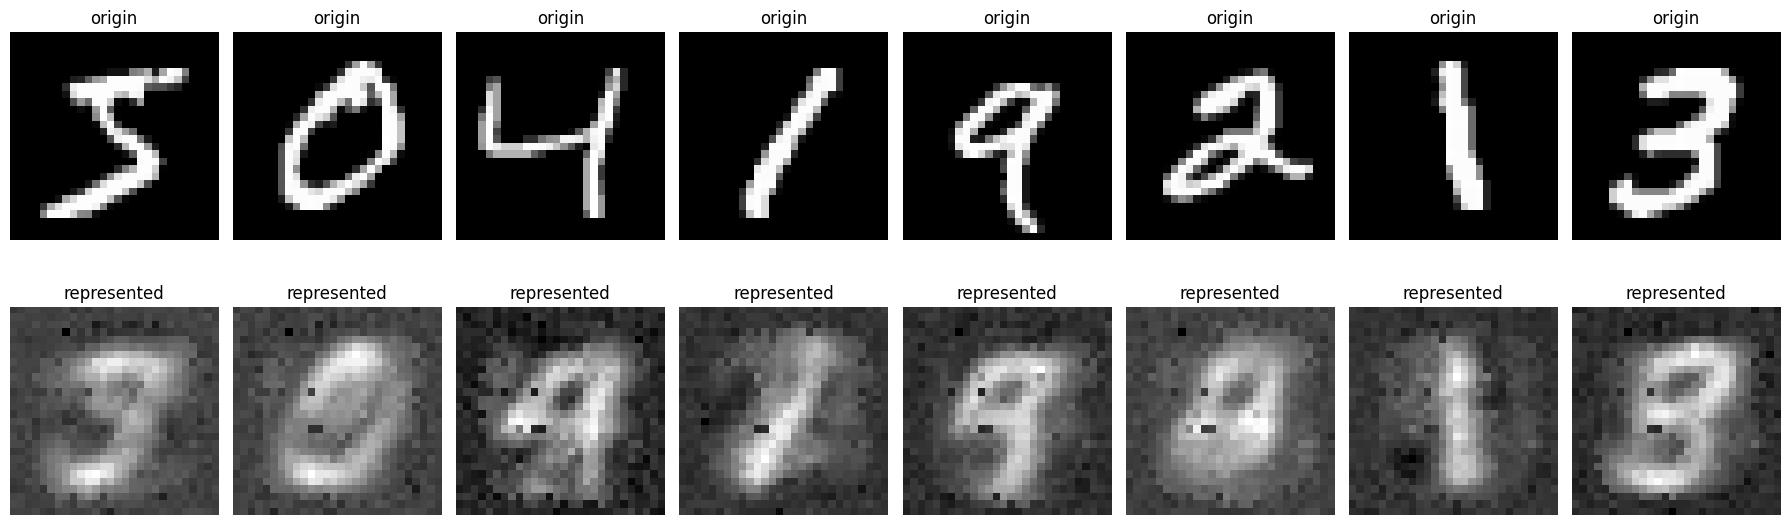

In [421]:
# encoder를 통과한 이미지를 visualization

X_encoded = encoder.predict(X_train)

visualization(X_train, X_encoded)


**글자가 매우 흐리게 보인다. encoder가 정보를 잘 압축하고 있음을 나타내는 지표가 되겠다.** 그러면 decoder에서 단계적으로 어떻게 이미지가 복구가 되는지 시각화해보자. decoder에 해당되는 layer를 차례대로 추가시키면서 시각화하면 되지 않겠는가?

                              Layer Type  Layer Name  Layer Trainable
0  <Flatten name=flatten_38, built=True>  flatten_38            False
1     <Dense name=dense_267, built=True>   dense_267            False
2     <Dense name=dense_268, built=True>   dense_268            False
3     <Dense name=dense_269, built=True>   dense_269            False
4     <Dense name=dense_270, built=True>   dense_270            False
5     <Dense name=dense_271, built=True>   dense_271            False
6     <Dense name=dense_276, built=True>   dense_276             True
7  <Reshape name=reshape_91, built=True>  reshape_91             True
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


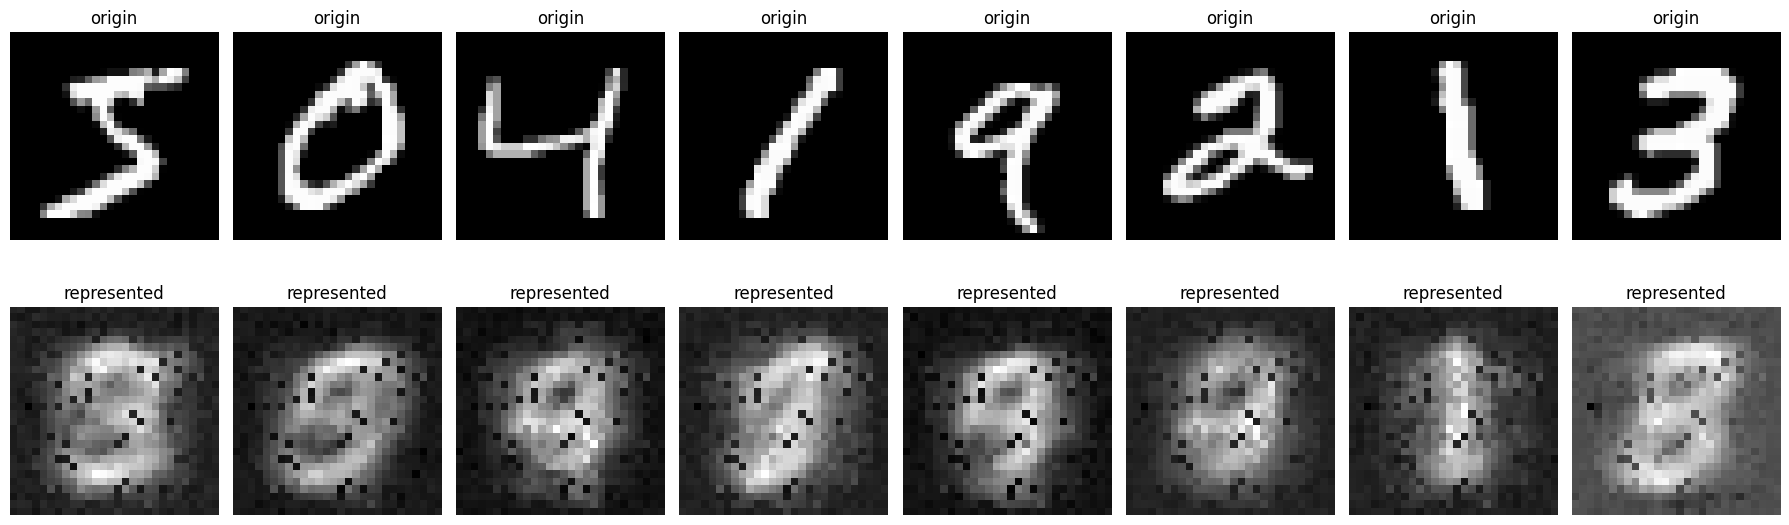

                              Layer Type  Layer Name  Layer Trainable
0  <Flatten name=flatten_38, built=True>  flatten_38            False
1     <Dense name=dense_267, built=True>   dense_267            False
2     <Dense name=dense_268, built=True>   dense_268            False
3     <Dense name=dense_269, built=True>   dense_269            False
4     <Dense name=dense_270, built=True>   dense_270            False
5     <Dense name=dense_271, built=True>   dense_271            False
6     <Dense name=dense_272, built=True>   dense_272            False
7     <Dense name=dense_277, built=True>   dense_277             True
8  <Reshape name=reshape_92, built=True>  reshape_92             True
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


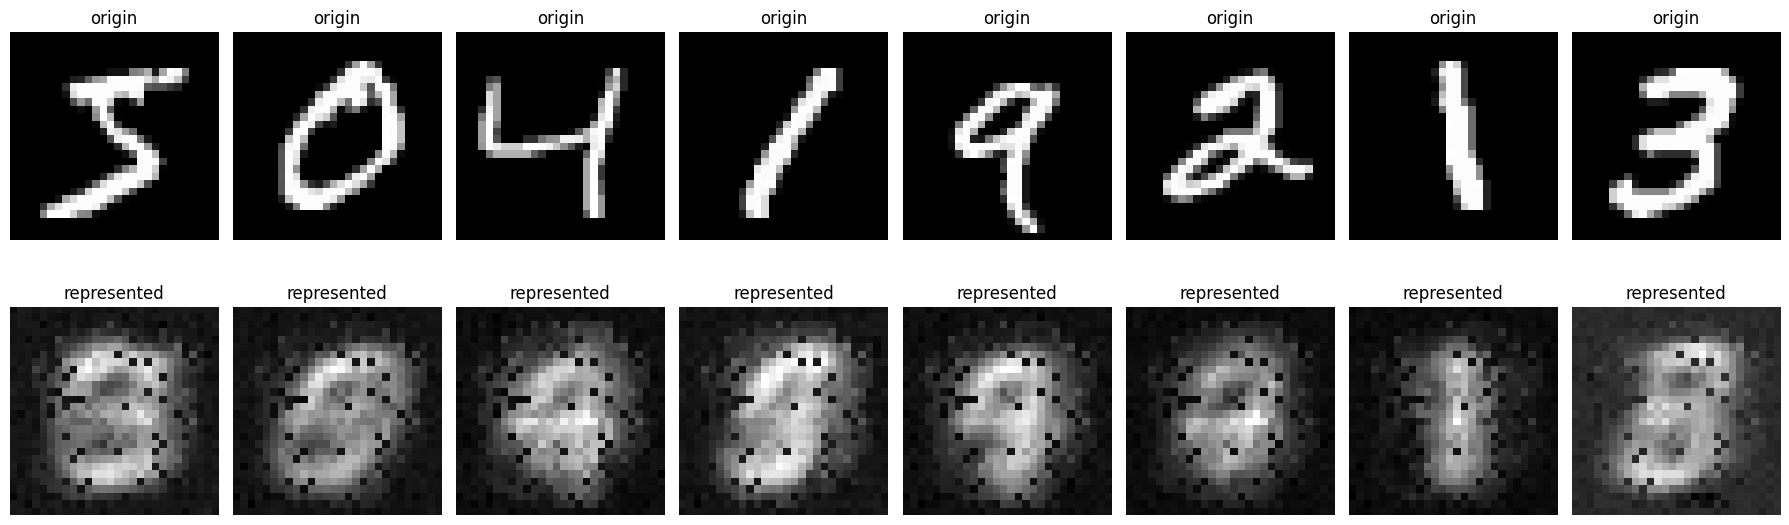

                              Layer Type  Layer Name  Layer Trainable
0  <Flatten name=flatten_38, built=True>  flatten_38            False
1     <Dense name=dense_267, built=True>   dense_267            False
2     <Dense name=dense_268, built=True>   dense_268            False
3     <Dense name=dense_269, built=True>   dense_269            False
4     <Dense name=dense_270, built=True>   dense_270            False
5     <Dense name=dense_271, built=True>   dense_271            False
6     <Dense name=dense_272, built=True>   dense_272            False
7     <Dense name=dense_273, built=True>   dense_273            False
8     <Dense name=dense_278, built=True>   dense_278             True
9  <Reshape name=reshape_93, built=True>  reshape_93             True
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


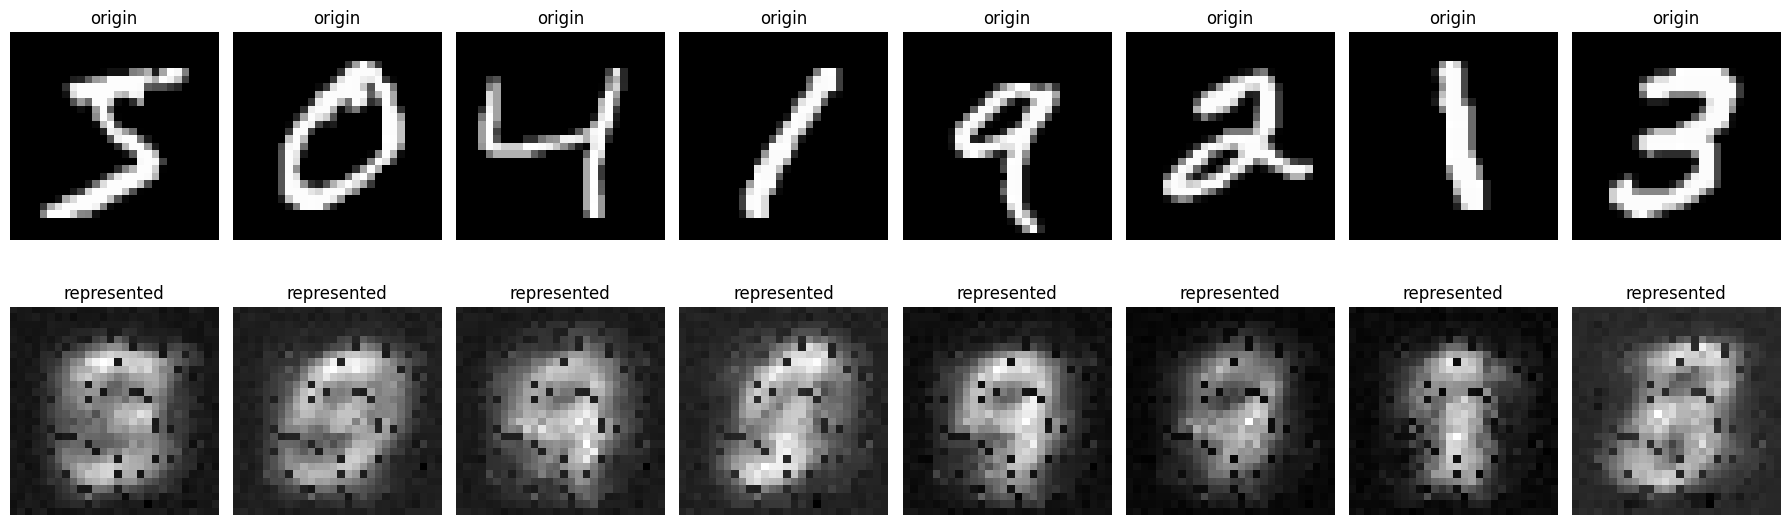

In [422]:
# decoder layer를 하나씩 추가하면서 시각화

encoder.pop()
encoder.pop()

encoder.add(base_model.layers[4]) # bottleneck을 추가하였다

for layer in [base_model.layers[i] for i in range (5, 8)] : # decoder 부분을 차례대로 추가
    encoder.add(layer)
    
    latent_dim = 784  # Flatten된 이미지 크기
    encoder.add(Dense(latent_dim))  # Dense 레이어 추가하여 크기 맞추기
    encoder.add(Reshape((28, 28, 1)))  # 원하는 형상으로 Reshape
    
    display_layers = [(layer, layer.name, layer.trainable) for layer in encoder.layers]
    print (pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

    
    # 재학습
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.fit(X_train, X_train,
                    epochs=25,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(X_test, X_test), 
                verbose=False)
        
    X_encoded = encoder.predict(X_train)

    visualization(X_train, X_encoded)
    
    encoder.pop()
    encoder.pop()